In [ ]:
# !pip install matplotlib

  Using cached matplotlib-3.10.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp312-cp

In [5]:
from pathlib import Path
from rosbags.highlevel import AnyReader
from pathlib import Path
from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore
from pyproj import Transformer
from scipy.spatial.transform import Rotation as R
import pandas as pd

# ---------------- setup ----------------
bagpath = Path("First_test_v1.bag")
typestore = get_typestore(Stores.ROS2_JAZZY)

bagpath = Path("First_test_v1.bag")

# with AnyReader([bagpath]) as reader:
#     topics = sorted({c.topic for c in reader.connections})

# for t in topics:
#     print(t)
    
required_topics = {
    # '/fixposition/odometry_ecef',
    # '/motor_feedback',
    '/steering_pub'
}

# ---------------- read bag ----------------
with AnyReader([bagpath], default_typestore=typestore) as reader:
    connections = [c for c in reader.connections if c.topic in required_topics]

    for c, t, raw in reader.messages(connections=connections):
        msg = reader.deserialize(raw, c.msgtype)
        print(msg)
        break

geometry_msgs__msg__Twist(linear=geometry_msgs__msg__Vector3(x=-5.0, y=0.0, z=0.0, __msgtype__='geometry_msgs/msg/Vector3'), angular=geometry_msgs__msg__Vector3(x=0.0, y=0.0, z=0.0, __msgtype__='geometry_msgs/msg/Vector3'), __msgtype__='geometry_msgs/msg/Twist')


In [25]:
from pathlib import Path
from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore
from pyproj import Transformer
from scipy.spatial.transform import Rotation as R
import pandas as pd

# ---------------- setup ----------------
bagpath = Path("day3_trail4_forced_v7.bag")
typestore = get_typestore(Stores.ROS2_JAZZY)

transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)

required_topics = {
    '/fixposition/odometry_ecef',
    '/motor_feedback',
    '/steering_pub'
}

rows = []

# ---------------- read bag ----------------
with AnyReader([bagpath], default_typestore=typestore) as reader:
    connections = [c for c in reader.connections if c.topic in required_topics]

    for c, t, raw in reader.messages(connections=connections):
        msg = reader.deserialize(raw, c.msgtype)
        time = t * 1e-9  # ns → seconds

        row = {"time": time}

        # -------- odometry --------
        if c.topic == '/fixposition/odometry_ecef':
            p = msg.pose.pose.position
            q = msg.pose.pose.orientation
            v = msg.twist.twist.linear

            lon, lat, alt = transformer.transform(p.x, p.y, p.z)
            yaw, pitch, roll = R.from_quat(
                [q.x, q.y, q.z, q.w]
            ).as_euler("zyx", degrees=True)

            row.update({
                "lat": lat,
                "lon": lon,
                "alt": alt,
                "yaw": yaw,
                "pitch": pitch,
                "roll": roll,
                "vx":v.x,
                "vy":v.y,
                "vz":v.z,
                "v_speed": (v.x**2 + v.y**2) ** 0.5
            })

        # -------- motor feedback --------
        if c.topic == '/motor_feedback':
            row.update({
                "pos": msg.data[0],
                "rpm": msg.data[1],
                "curr": msg.data[2],
                "temp": msg.data[3],
                "err": msg.data[4]
            })

        # -------- steering --------
        if c.topic == '/steering_pub':
            row.update({
                "steering_vel": msg.linear.x
            })

        rows.append(row)

# ---------------- dataframe ----------------
df = pd.DataFrame(rows).sort_values("time")
df = df.set_index("time").interpolate()


<Axes: xlabel='time'>

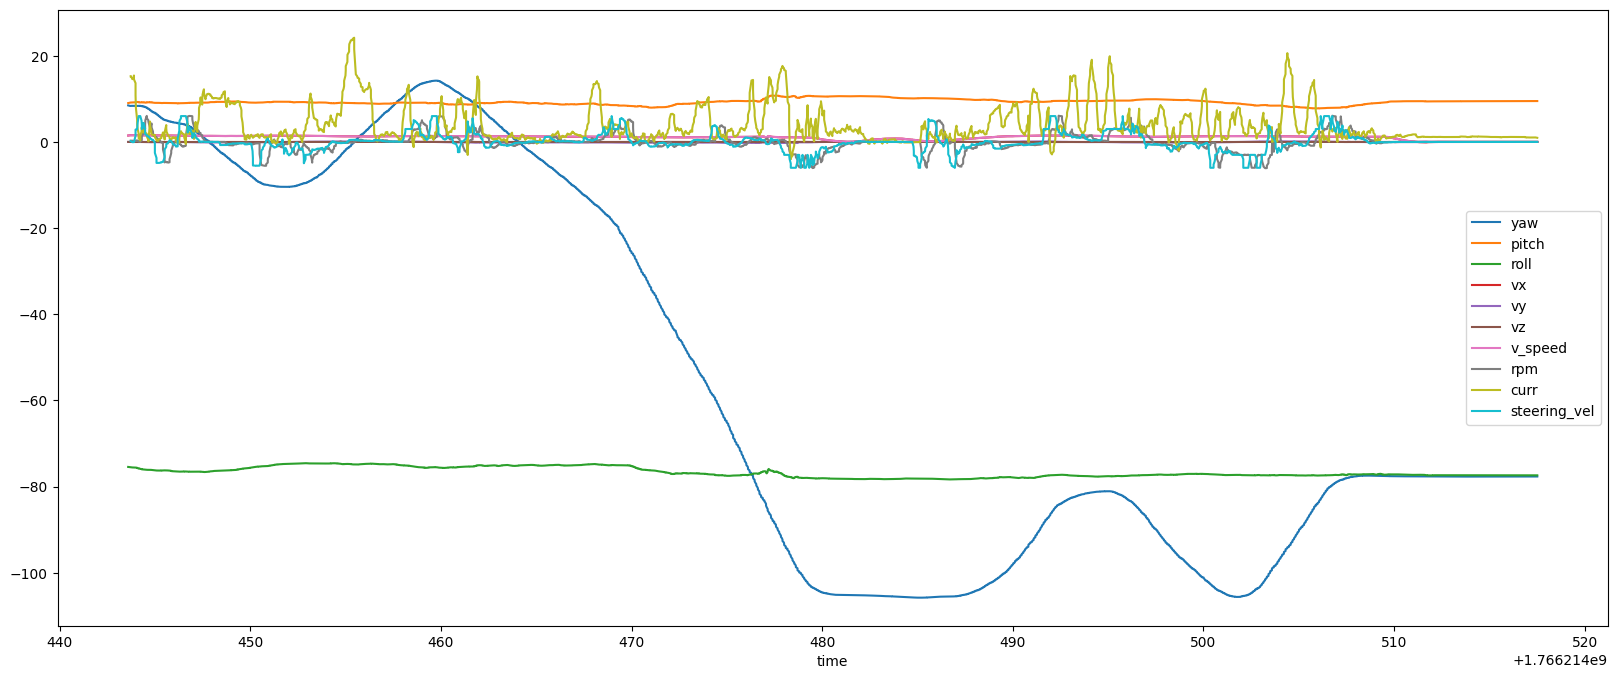

In [29]:
ploting_df = df.copy()
drop_col = ['alt' , 'temp' , 'err' , 'alt','lon','lat','pos']
ploting_df.drop(drop_col, axis=1, inplace=True)
ploting_df.steering_vel = ploting_df.steering_vel/1000
ploting_df.rpm = ploting_df.rpm/1000
ploting_df.plot(kind='line' , figsize=(20,8))

<Axes: xlabel='time'>

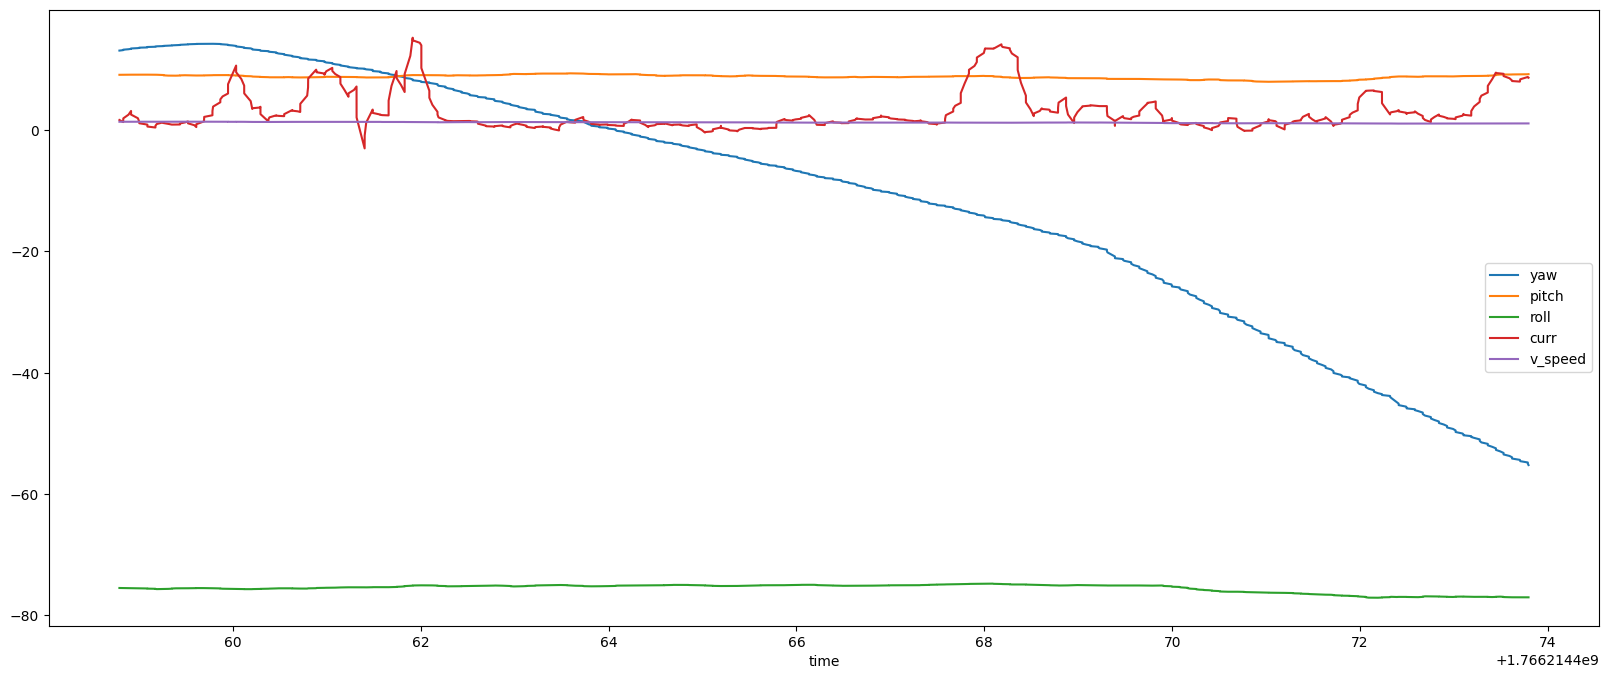

In [31]:
to_view = ['yaw' , 'pitch' , 'roll' , 'curr' , 'v_speed']
ploting_df = df[to_view]
ploting_df.iloc[500:1000].plot(kind='line' , figsize=(20,8))

In [ ]:
import folium
import rosbag
from pyproj import Transformer

from scipy.spatial.transform import Rotation as R
from folium.plugins import PolyLineTextPath

chennai_map = folium.Map(location=[12.97, 80.22], zoom_start=20, max_zoom=25)#, max_zoom=22

# Create transformer: ECEF (EPSG:4978) → WGS84 geographic (EPSG:4326)
transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)

bag = rosbag.Bag("/home/asl/Muni/datasets/vision_nav_data/new_sesor_steup.bag", allow_unindexed = True)

# for topic, msg, time_stamp in bag.read_messages(topics=['/fixposition/gnss1']):
#     folium.CircleMarker(location=(msg.latitude, msg.longitude), radius=1, fill=True).add_to(chennai_map)

# for topic, msg, time_stamp in bag.read_messages(topics=['/fixposition/gnss2']):
#     folium.CircleMarker(location=(msg.latitude, msg.longitude), radius=1, fill=True, color = "red").add_to(chennai_map)

points = []
yaws = []

for topic, msg, time_stamp in bag.read_messages(topics=['/imu_gps_synced_data']):
    # folium.CircleMarker(location=(msg.latitude, msg.longitude), radius=1, fill=True, color = "red").add_to(chennai_map)
    # print(msg)
    # exit(0)
    Pose = msg.odometry_ecef.pose.pose.position
    Orientation = msg.odometry_ecef.pose.pose.orientation

    # Convert from ECEF → Lat/Lon/Alt
    lon, lat, alt = transformer.transform(Pose.x, Pose.y, Pose.z)
    
    points.append([lat, lon])

    # Quaternion → Yaw
    r = R.from_quat([Orientation.x, Orientation.y, Orientation.z, Orientation.w])
    _, _, yaw = r.as_euler('xyz', degrees=True)
    yaws.append(yaw)

bag.close()

# ---- Plot Trajectory ----
# Option 1: draw small points
for lat, lon in points[::10]:  # plot every 10th point for speed
    folium.CircleMarker(location=[lat, lon], radius=1, color="red", fill=True).add_to(chennai_map)

# print(points)
# folium.PolyLine(points, color="blue", weight=2).add_to(chennai_map)


# Draw trajectory as blue line
path = folium.PolyLine(points, color="blue", weight=2.5).add_to(chennai_map)

# Add directional arrows along the path
PolyLineTextPath(
    path,
    '▶',  # Arrow symbol
    repeat=True,
    offset=5,
    attributes={'fill': 'red', 'font-weight': 'bold', 'font-size': '12'}
).add_to(chennai_map)

chennai_map.save("fp_osm.html")
